In [1]:
import os
import numpy as np
import torch
import torchvision.transforms
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from sklearn.manifold import TSNE
from torch.utils.data import Dataset, DataLoader

# EmbeddingImageDataset

## Overview
`EmbeddingImageDataset` is a PyTorch `Dataset` class designed to load image-embedding pairs from a given directory structure. It loads images, applies transformations, and reads corresponding embeddings stored in `.h5` files.

## Initialization
### `__init__(self, imagePath, embeddingPath, classRange=None, transform=None)`
#### Parameters:
- `imagePath` (*str*): Path to the directory containing images.
- `embeddingPath` (*str*): Path to the directory containing embeddings stored as `.h5` files.
- `classRange` (*tuple, optional*): A tuple `(start, end)` defining the range of class directories to load. If `None`, all directories are considered.
- `transform` (*callable, optional*): A transformation function for image preprocessing. Defaults to `torchvision.transforms.ToTensor()`.

#### Functionality:
- Reads subdirectories within `embeddingPath`.
- Iterates through `.h5` embedding files, matches them with corresponding images.
- Loads images, applies transformations, and reads embeddings from `.h5` files.
- Pads embeddings to a fixed size of `306` and stacks them.
- Stores image-embedding-label tuples in `self.samples`.

---

## Dataset Methods

### `__len__(self)`
#### Returns:
- (*int*): The number of samples in the dataset.

### `__getitem__(self, index)`
#### Parameters:
- `index` (*int*): The index of the sample to retrieve.

#### Returns:
- A tuple `(image, embedding, class_index)`, where:
  - `image` (*Tensor*): The transformed image.
  - `embedding` (*Tensor*): The stacked and padded embedding tensor.
  - `class_index` (*int*): The class label index.
```

In [2]:
class EmbeddingImageDataset(Dataset):
    def __init__(self, imagePath, embeddingPath, classRange=None, transform=None):
        self.imagePath = imagePath
        self.embeddingPath = embeddingPath
        self.transform = transform if transform is not None else torchvision.transforms.ToTensor()
        self.samples = []
        
        classDirectory = sorted(os.listdir(embeddingPath))
        classDirectory = classDirectory[classRange[0]:classRange[1]] if classRange is not None else classDirectory
        
        for idx, d in enumerate(classDirectory):
            embeddingFiles = [f for f in os.listdir(os.path.join(embeddingPath, d)) if f.lower().endswith('.h5')]
            for f in embeddingFiles:
                imgName = os.path.splitext(f)[0]
                imgFile = os.path.join(imagePath, imgName + '.jpg')
                embeddingFile = os.path.join(embeddingPath, d, f)
                
                img = Image.open(imgFile).convert('RGB')
                img = self.transform(img)
                
                with h5py.File(embeddingFile, 'r') as hf:
                    keys = list(hf.keys())
                    embedding = [torch.tensor(hf[key][()]) for key in keys]
                    
                    for i in range(len(embedding)):
                        embedLen = embedding[i].size(0)
                        pad = torch.zeros(306 - embedLen, dtype=embedding[i].dtype)
                        embedding[i] = torch.cat((embedding[i], pad))
                    
                    embedding = torch.stack(embedding, dim=0)
                
                self.samples.append((img, embedding, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return self.samples[index]

In [3]:
image_path = "jpg"
embeddings_path = "text_c10"

#Train dataset of classes 1 to 20
train_dataset = EmbeddingImageDataset(
    imagePath=image_path,
    embeddingPath=embeddings_path,
    classRange=(0,20),
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((64,64)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
)

#Test dataset of classes 20 to 25
test_dataset = EmbeddingImageDataset(
    imagePath=image_path,
    embeddingPath=embeddings_path,
    classRange=(20,25),
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((64,64)),
        torchvision.transforms.ToTensor()
    ])
)

In [4]:
sample = train_dataset[0]
print(len(train_dataset))
image, embedding, class_index = sample

print("Class index:", class_index)
print("Embedding:", embedding[2].shape)
print("Image shape:", image.shape)

1155
Class index: 0
Embedding: torch.Size([306])
Image shape: torch.Size([3, 64, 64])


# Pix2Pix Architecture

### Overview
The Pix2Pix architecture is a generative adversarial network (GAN) designed for image-to-image translation tasks. It consists of a generator network based on a U-Net and a PatchGAN discriminator.

### U-Net Generator with Skip Connections
The generator in Pix2Pix follows a U-Net architecture, which consists of an encoder-decoder structure. The encoder progressively down-samples the input image, extracting feature representations, while the decoder up-samples to reconstruct the output image. Skip connections are used to directly connect corresponding layers in the encoder and decoder, preserving spatial details.

In this implementation, the generator takes an input image and concatenates it with an embedding tensor. The embeddings are processed through a fully connected layer before being reshaped and merged into the decoder stage of the U-Net.

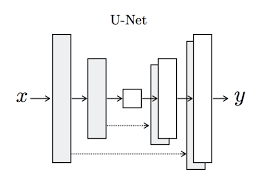
#### Input Image and Embeddings Processing
- The input to the generator is a `3 × 64 × 64` image.
- The image is progressively downsampled through convolutional layers:
  - `3 × 64 × 64 → 32 × 32 × 32 → 64 × 16 × 16 → 128 × 8 × 8 → 512 × 4 × 4`
  - This captures hierarchical features while reducing spatial dimensions.
- The text embedding is a `B × 306 × 10` tensor.
- It is passed through a fully connected (`fc`) layer that transforms it into a `B × 306 × 16` shape.
- The reshaped embedding is then converted into `B × 306 × 4 × 4`.
- This processed embedding is concatenated with the deepest U-Net layer (`512 × 4 × 4`) before the upsampling begins.
- The upsampling path reconstructs the image while concatenating features from the encoder via skip connections.
- The final output is a `3 × 64 × 64` image after passing through a `Tanh` activation.

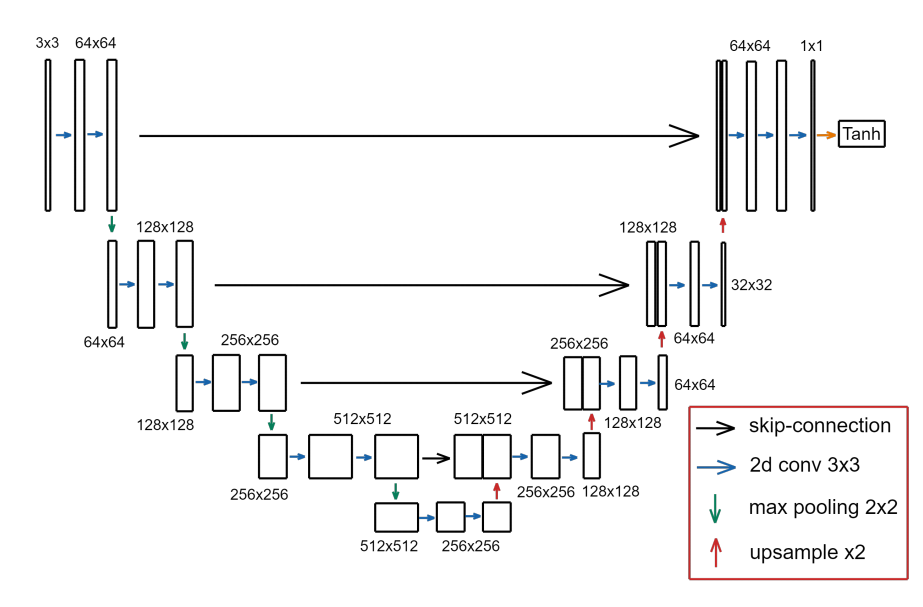

### PatchGAN Discriminator
The discriminator, known as PatchGAN, does not classify the entire image as real or fake but instead evaluates local patches. This encourages finer details in the generated images. The discriminator consists of a series of convolutional layers that down-sample the input, followed by a final classification layer that outputs a probability map.

In [5]:
import torch
import torch.nn as nn

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect") if down else
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if not down else nn.LeakyReLU(0.2),
        )
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=32):
        super().__init__()

        self.down1 = UNetBlock(in_channels, features, down=True, use_dropout=False)
        self.down2 = UNetBlock(features, features * 2, down=True, use_dropout=False)
        self.down3 = UNetBlock(features * 2, features * 4, down=True, use_dropout=False)
        self.down4 = UNetBlock(features * 4, features * 8, down=True, use_dropout=False)

        self.up1 = UNetBlock(features * 8 + 306, features * 4, down=False, use_dropout=True)
        self.up2 = UNetBlock(features * 4 * 2, features * 2, down=False, use_dropout=True)
        self.up3 = UNetBlock(features * 2 * 2, features, down=False, use_dropout=False)
        self.final = nn.ConvTranspose2d(features * 2, in_channels, 4, 2, 1)
        self.tanh = nn.Tanh()

        self.fc = nn.Linear(10, 16)

    def forward(self, x, embedding):
        B, _, _ = embedding.shape
        
        embedding = embedding.float()
        embedding = embedding.squeeze(-1).permute(0, 2, 1)
        embedding = self.fc(embedding)
        embedding = embedding.view(B, 306, 4, 4)

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(torch.cat([d4, embedding], dim=1))
        u2 = self.up2(torch.cat([u1, d3], dim=1))
        u3 = self.up3(torch.cat([u2, d2], dim=1))

        return self.tanh(self.final(torch.cat([u3, d1], dim=1))), d4

In [6]:
import torch
import torch.nn as nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]

        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
        )
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        return x

In [7]:
#Xavier weight initialization
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)

In [ ]:
#Hyperparameters and Model Loading

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(in_channels=3, features=32).to(device)
discriminator = Discriminator(in_channels=3).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

NUM_EPOCHS = 30
BATCH_SIZE = 8
LEARNING_RATE = 1e-4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

c:\Users\critz\miniconda3\envs\venv\lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


In [9]:

def denormalize(tensor):
    return (tensor + 1) / 2

def show_images(real_imgs, fake_imgs, real_scores, fake_scores, epoch, step, n=4):
    n = min(n, real_imgs.size(0), fake_imgs.size(0))
    
    real_imgs = real_imgs[:n].detach().cpu()
    fake_imgs = fake_imgs[:n].detach().cpu()
    real_imgs = denormalize(real_imgs).clamp(0,1)
    fake_imgs = denormalize(fake_imgs).clamp(0,1)

    real_scores = real_scores[:n].detach().cpu().numpy()
    fake_scores = fake_scores[:n].detach().cpu().numpy()
    
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    fig.suptitle(f"Epoch {epoch+1}, Step {step}")
    for j in range(n):
        axes[0, j].imshow(np.transpose(real_imgs[j].numpy(), (1,2,0)))
        axes[0, j].axis("off")
        axes[0, j].set_title(f"Real D={real_scores[j].mean().item():.2f}")

        axes[1, j].imshow(np.transpose(fake_imgs[j].numpy(), (1,2,0)))
        axes[1, j].axis("off")
        axes[1, j].set_title(f"Fake D={fake_scores[j].mean().item():.2f}")
    plt.tight_layout()
    plt.show()

# Training Loop Explanation
The training loop follows the standard GAN training paradigm, alternating between updating the discriminator and generator.

1. **Discriminator Training:**
   - The real images and corresponding embeddings are loaded.
   - The generator produces fake images using the input image and embeddings.
   - The discriminator predicts real/fake for both real and generated images.
   - Binary cross-entropy loss (`BCELoss`) is used to calculate `D_real_loss` (for real images) and `D_fake_loss` (for fake images).
   - The discriminator is updated by minimizing `(D_real_loss + D_fake_loss) / 2`.

2. **Generator Training:**
   - The generator produces fake images again.
   - The discriminator's prediction on fake images (`D_fake`) is obtained.
   - The generator is optimized using two losses:
     - Adversarial loss (`BCELoss` against real labels) to fool the discriminator.
     - L1 loss (`L1Loss`) to ensure the generated image closely matches the real one.
   - The generator is updated by minimizing `G_fake_loss + 100 * L1`.

3. **Visualization and Monitoring:**
   - Every 100 iterations, real and generated images along with discriminator scores are visualized using `show_images()`.

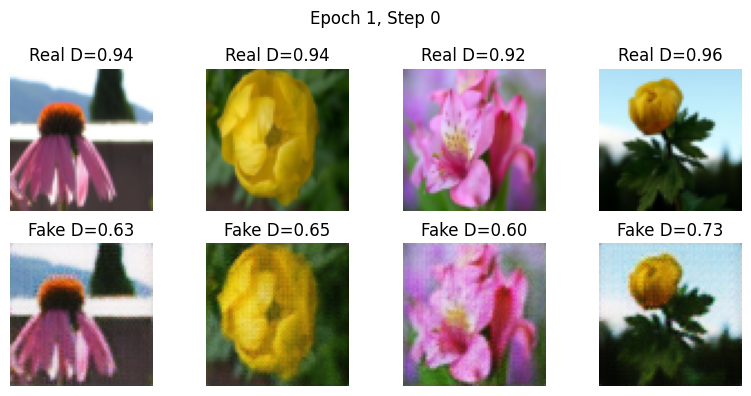

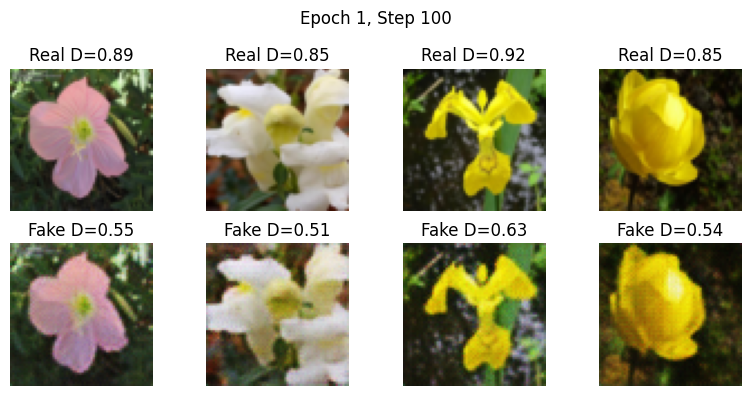

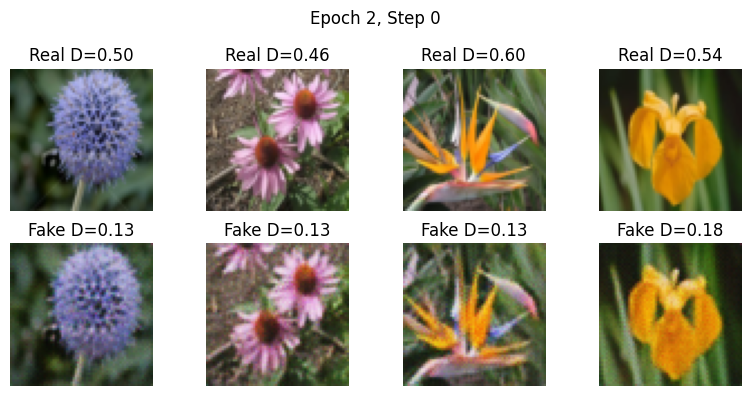

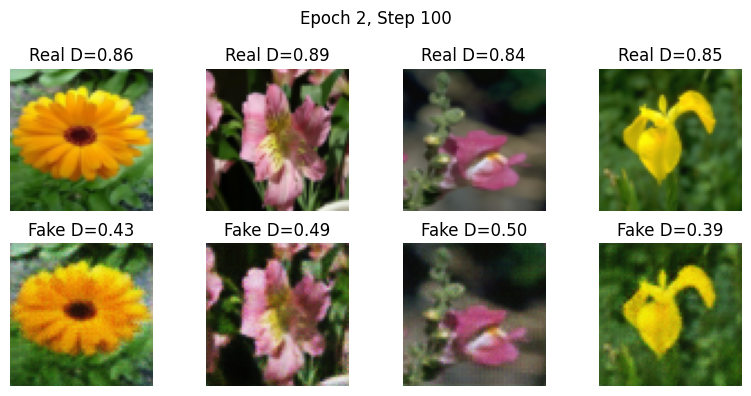

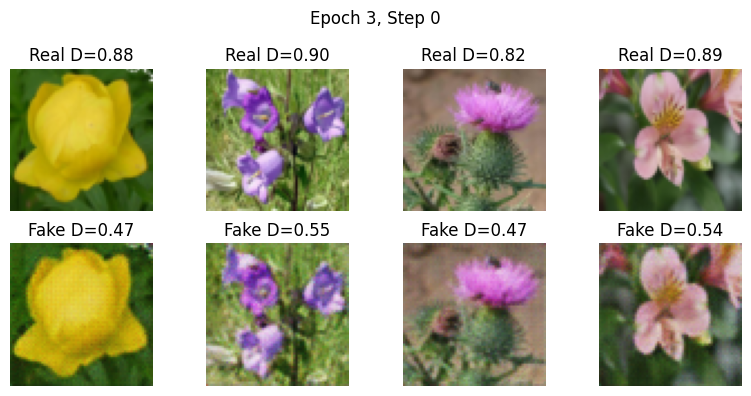

KeyboardInterrupt: 

In [18]:
criterion = torch.nn.BCELoss()
l1_loss = torch.nn.L1Loss()

optD = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optG = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

for epoch in range(NUM_EPOCHS):
    for i, batch in enumerate(train_loader):
        real_imgs = batch[0].to(device)
        text_enc = batch[1].to(device)
        B = real_imgs.size(0)

        label_real = torch.ones((B, 1, 6, 6), device=device)  
        label_fake = torch.zeros((B, 1, 6, 6), device=device)

        optD.zero_grad()
        fake, _ = generator(real_imgs, text_enc)  
        
        D_real = discriminator(real_imgs)
        D_real_loss = criterion(D_real, label_real)

        D_fake = discriminator(fake.detach())
        D_fake_loss = criterion(D_fake, label_fake)

        D_loss = (D_real_loss + D_fake_loss) / 2
        D_loss.backward()
        optD.step()

        optG.zero_grad()
        fake, _ = generator(real_imgs, text_enc)
        
        D_fake = discriminator(fake)
        G_fake_loss = criterion(D_fake, label_real)  
        
        L1 = l1_loss(fake, real_imgs) * 100  
        G_loss = G_fake_loss + L1

        G_loss.backward()
        optG.step()

        if i % 100 == 0:
            with torch.no_grad():
                real_scores = discriminator(real_imgs)
                fake_scores = discriminator(fake)
            show_images(real_imgs, fake, real_scores, fake_scores, epoch, i, n=4)

print("Training finished")

In [ ]:
def get_model_stats(model, params_list):
    total_params = sum(p.numel() for p in params_list)
    trainable_params = sum(p.numel() for p in params_list if p.requires_grad)
    
    tmp_path = "tmp_model.pth"
    torch.save(model.state_dict(), tmp_path)
    size_on_disk = os.path.getsize(tmp_path) / 1e6
    os.remove(tmp_path)

    return total_params, trainable_params, size_on_disk

encoder_params = list(generator.down1.parameters()) + \
                 list(generator.down2.parameters()) + \
                 list(generator.down3.parameters()) + \
                 list(generator.down4.parameters())

generator_params = list(generator.up1.parameters()) + \
                   list(generator.up2.parameters()) + \
                   list(generator.up3.parameters()) + \
                   list(generator.final.parameters()) + \
                   list(generator.fc.parameters())

enc_total, enc_trainable, enc_size = get_model_stats(generator, encoder_params)
print(f"SourceEncoder Stats:")
print(f"  Total Params:      {enc_total}")
print(f"  Trainable Params:  {enc_trainable}")
print(f"  Model Size on Disk: {enc_size:.2f} MB\n")

gen_total, gen_trainable, gen_size = get_model_stats(generator, generator_params)
print(f"Generator Stats:")
print(f"  Total Params:      {gen_total}")
print(f"  Trainable Params:  {gen_trainable}")
print(f"  Model Size on Disk: {gen_size:.2f} MB\n")

disc_total, disc_trainable, disc_size = get_model_stats(discriminator, list(discriminator.parameters()))
print(f"Discriminator Stats:")
print(f"  Total Params:      {disc_total}")
print(f"  Trainable Params:  {disc_trainable}")
print(f"  Model Size on Disk: {disc_size:.2f} MB\n")

SourceEncoder Stats:
  Total Params:      690624
  Trainable Params:  690624
  Model Size on Disk: 8.71 MB

Generator Stats:
  Total Params:      1482355
  Trainable Params:  1482355
  Model Size on Disk: 8.71 MB

Discriminator Stats:
  Total Params:      2765633
  Trainable Params:  2765633
  Model Size on Disk: 11.08 MB



In [12]:
#Saving the models

torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

C:\Users\critz\AppData\Local\Temp\ipykernel_14036\859465959.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth", map_loc

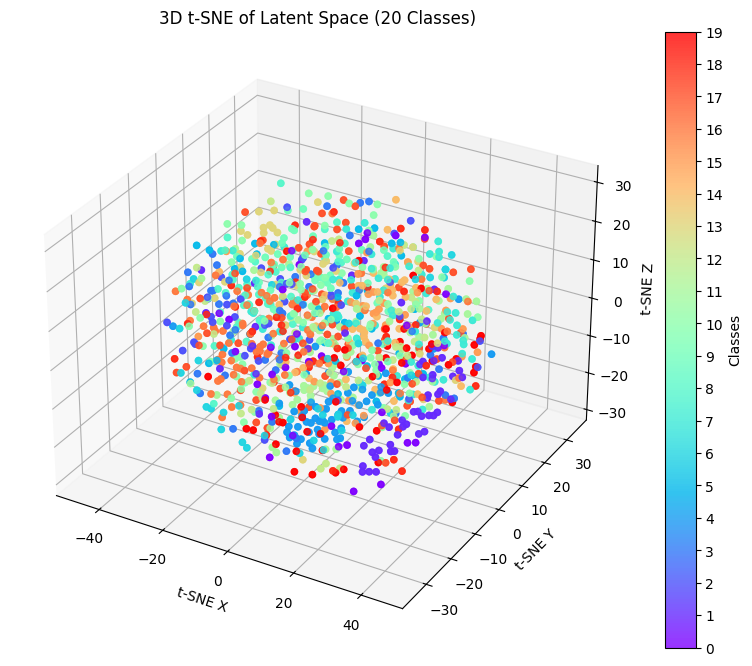

In [13]:
#Plotting 3D T-SNE of Latent Space of all 20 train classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)

if not os.path.exists("generator.pth"):
    raise FileNotFoundError("Error: 'generator.pth' not found! Make sure to save the model.")

generator.load_state_dict(torch.load("generator.pth", map_location=device))
generator.eval()

latent_vectors = []
labels = []

with torch.no_grad():
    for batch in train_loader:
        real_imgs, text_enc, class_labels = batch
        real_imgs, text_enc = real_imgs.to(device), text_enc.to(device)

        gen_output = generator(real_imgs, text_enc)
        if isinstance(gen_output, tuple):
            fake_imgs, latent = gen_output 
        else:
            raise ValueError("Error: Generator must return both (image, latent space)")

        latent = latent.view(latent.size(0), -1)  
        latent_vectors.append(latent.cpu().numpy())
        labels.extend(class_labels.numpy())  

latent_vectors = np.concatenate(latent_vectors, axis=0)

tsne = TSNE(n_components=3, perplexity=100, random_state=42)  
latent_3d = tsne.fit_transform(latent_vectors)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], 
    c=labels, cmap='rainbow', alpha=0.8
)

scatter = ax.scatter(
    latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], 
    c=labels, cmap='rainbow', alpha=0.8
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_ticks(np.arange(20))
cbar.set_label("Classes")

ax.set_title("3D t-SNE of Latent Space (20 Classes)")
ax.set_xlabel("t-SNE X")
ax.set_ylabel("t-SNE Y")
ax.set_zlabel("t-SNE Z")

plt.show()

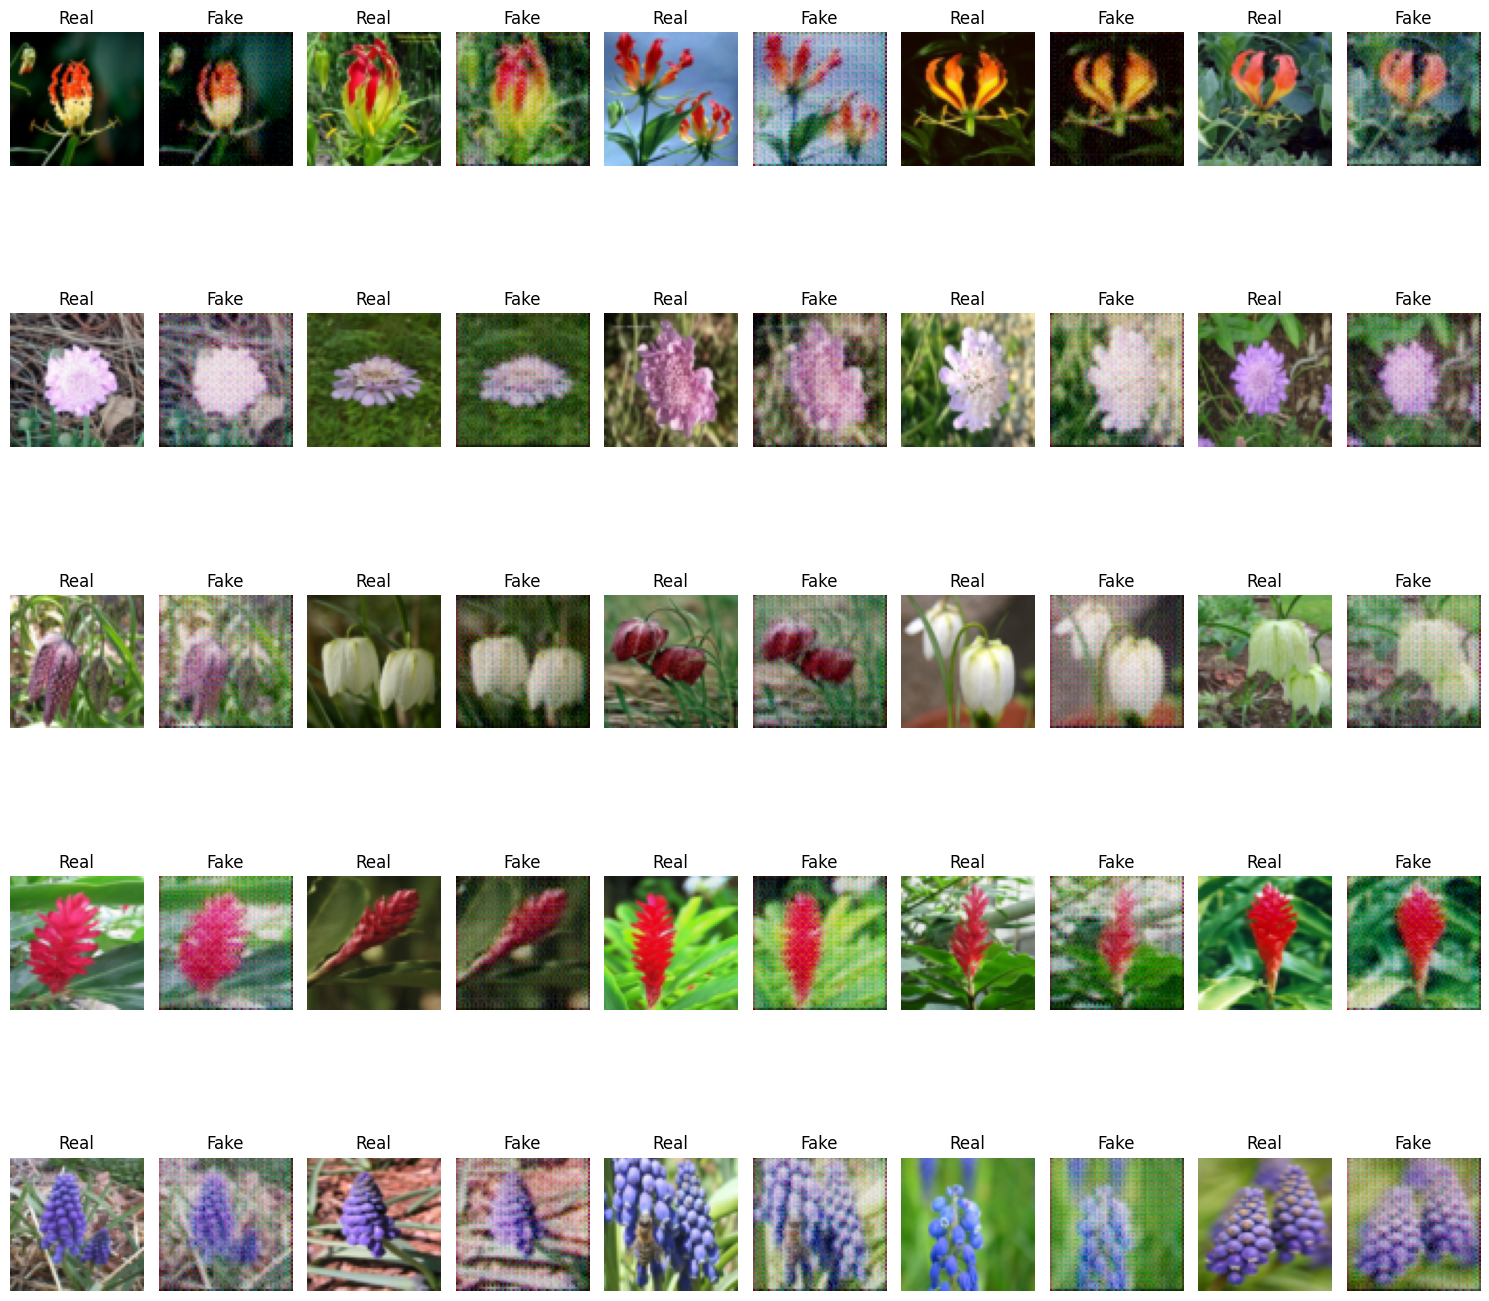

In [14]:
#Testing on 5 classes

def get_test_samples(test_loader, num_classes=5, samples_per_class=5):
    """
    Collect `samples_per_class` images from `num_classes` different classes.
    """
    class_dict = {i: [] for i in range(num_classes)}  
    for batch in test_loader:
        img, emb, cls = batch  
        
        for i in range(len(cls)):  
            class_idx = cls[i].item()  
            if class_idx in class_dict and len(class_dict[class_idx]) < samples_per_class:
                class_dict[class_idx].append((img[i], emb[i]))  
                
        if all(len(v) == samples_per_class for v in class_dict.values()):
            break

    all_images, all_embeddings = [], []
    for class_samples in class_dict.values():
        for img, emb in class_samples:
            all_images.append(img)
            all_embeddings.append(emb)

    return torch.stack(all_images), torch.stack(all_embeddings)

num_classes = 5
samples_per_class = 5
test_images, test_embeddings = get_test_samples(test_loader, num_classes, samples_per_class)

test_images = test_images.to(device)
test_embeddings = test_embeddings.to(device)

generator.eval()
with torch.no_grad():
    fake_images, _ = generator(test_images, test_embeddings) 
    
real_images = test_images.cpu().detach()
fake_images = fake_images.cpu().detach()

fig, axes = plt.subplots(num_classes, samples_per_class * 2, figsize=(samples_per_class * 3, num_classes * 3))

for i in range(num_classes):
    for j in range(samples_per_class):
        idx = i * samples_per_class + j 
        
        axes[i, j * 2].imshow(real_images[idx].permute(1, 2, 0).numpy().clip(0, 1))
        axes[i, j * 2].axis("off")
        axes[i, j * 2].set_title(f"Real")

        axes[i, j * 2 + 1].imshow(fake_images[idx].permute(1, 2, 0).numpy().clip(0, 1))
        axes[i, j * 2 + 1].axis("off")
        axes[i, j * 2 + 1].set_title(f"Fake")

plt.tight_layout()
plt.show()